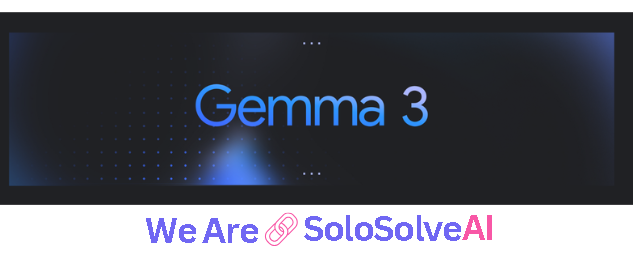

In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.1.1+cu121
CUDA available: True
CUDA version: 12.1
GPU Name: Quadro RTX 5000


In [2]:
!pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3 -q --upgrade
!pip install datasets pandas accelerate peft trl -q
#!pip uninstall bitsandbytes -y
#!pip install --force-reinstall 'https://github.com/bitsandbytes-foundation/bitsandbytes/releases/download/continuous-release_multi-backend-refactor/bitsandbytes-0.44.1.dev0-py3-none-manylinux_2_24_x86_64.whl'

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradient 2.0.6 requires attrs<=19, but you have attrs 23.1.0 which is incompatible.


In [3]:
import torch
from transformers import AutoTokenizer, Gemma3ForCausalLM, BitsAndBytesConfig
from huggingface_hub import notebook_login
from datasets import load_dataset
import pandas as pd
import json
import os
import warnings

warnings.filterwarnings('ignore')

2025-05-16 09:25:17.468633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 09:25:17.468699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 09:25:17.470512: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 09:25:17.480377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 09:25:18.505324: W tensorflow/compiler/tf2

In [4]:
notebook_login()

In [5]:
TEACHER_MODEL_ID = "google/gemma-3-4b-it" # Instruction-tuned model
RAW_DATASET_NAME = "McAuley-Lab/Amazon-Reviews-2023"
RAW_DATASET_CONFIG = "raw_review_Amazon_Fashion" # Using a smaller subset for example
CURATED_COMPLAINTS_FILE = "amazon_fashion_complaints_sample.parquet"
SFT_OUTPUT_FILE = "sft_complaint_resolution_dataset.jsonl"
SEED = 42

COMPLAINT_CATEGORIES = [
    "Item Damaged/Defective",
    "Wrong Item Received/Not as Pictured",
    "Sizing Issue (Too Small/Large/Inconsistent)",
    "Quality Issue (Poor Construction/Material)",
    "Missing Parts/Item",
    "Shipping & Delivery Issue", # Added based on common complaints
    "Other"
]

# --- AMAZON POLICY SNIPPET ---
# IMPORTANT: Replace this with the full, relevant Amazon policy text.
# For brevity in this snippet, only a placeholder is included.

AMAZON_POLICY_TEXT = """
=== Amazon Return Policy Summary ===

**Core Principle:** Most new, unopened items sold on Amazon.com can be returned for a refund or replacement/exchange within 30 days of delivery if in original or unused condition.

**1. Return Window:**
   - Standard: 30 days of delivery for most items.
   - Exceptions:
     - 7 days: Certain unread/undownloaded digital items (Kindle books, textbooks, music via Alexa).
     - 15 days: New Apple & Boost Infinite products; Amazon Haul items > $3.
     - 90 days: Amazon Renewed (Acceptable, Good, Excellent); most nonperishable Baby products; some gift list items.
     - 180 days: Amazon Wedding Registry items (by non-owner).
     - 365 days: Amazon Renewed (Premium); Amazon Baby Registry items (by non-owner).

**2. Non-Returnable Items:**
   - Perishables.
   - Products with health/safety risks once sold.
   - Products with shipping restrictions.
   - Customized products.
   - Redeemable products (e.g., gift cards, digital codes unless specified).
   - Amazon Pharmacy products.
   - Certain other digital products.
   - Automobiles.
   - "Final Sale" items (e.g., trading card games, specific discounted items, Amazon Haul items $3 and less).
   - **Exception for Non-Returnable/Final Sale:** If such an item arrives damaged, defective, or materially different from what was ordered, contact Customer Service. (Model Action: Advise customer to contact support, do not process standard return/refund via this automated flow).

**3. Condition of Returned Items:**
   - Must be in original or unused condition.
   - Original manufacturer's packaging including tags, components, accessories, manuals, shoe boxes, inserts.
   - Clothing, handbags, fashion items: Must have tags (product and security) and hygiene seals intact.
   - Luxury Stores items: Also include original brand/protective packaging and documentation.
   - Personal data on electronics (laptops, cameras) must be erased by the customer.

**4. Reasons for Return & Resolutions:**
   - **Damaged, Defective, or Broken Item / Materially Different:**
     - Resolution: Eligible for replacement of the exact item OR a full refund.
     - Process: Go to "Your Orders," select "Return or replace items."
     - Note: If a replacement order is immediately shipped, the original item must be returned by the "Return by" date to avoid being charged for both.
   - **Changed Mind / No Longer Needed (within 30 days, item in original/unused condition):**
     - Resolution: Eligible for refund.
     - Process: Standard return process.
   - **Item Not as Expected (Quality, Performance - not explicitly damaged/defective but doesn't meet reasonable expectations based on description):**
     - Policy is less explicit here. Decisions should be based on whether the item can be considered "materially different" or if it fails to perform its basic advertised function, potentially qualifying as defective in function.
     - Resolution: May be eligible for refund or replacement. If unclear, advise "Product Support Advised" or escalate for review. Avoid "Return_for_Refund_No_Return" unless explicitly stated for low-value items or specific promotions not covered here.

**5. Return Process:**
   - Initiate: Go to "Your Orders," click "Return or Replace Items." Select item and reason.
   - Refund/Replacement Choice: If applicable, select to issue a refund or replacement.
   - Return Method: Select preferred method (e.g., drop-off). Label-free, box-free available for many items.
   - Label & Packaging: Print label (if needed) and package items. Each label is for a specific return; do not mix orders.

**6. Refunds:**
   - Timeline: Generally 3-5 business days after Amazon processes the return (can take up to 30 days for Amazon to receive/process).
   - Method: Issued to original payment method or Amazon Gift Card balance.
   - **Partial Refunds / Fees (Deductions from Refund):**
     - Return Shipping Fee: If a non-free shipping method is chosen by the customer.
     - Late Fee (20% of item price): If item not returned by "return by date" after initiating return.
     - Damage Fee (up to 50%; 100% for Luxury Stores): If item returned damaged, missing parts, not in original condition, or with obvious signs of use (for reasons not due to Amazon/seller error).
     - Restocking Fee (100%): For opened/used/activated software, video games, collectible cards/games.
   - **"Return_for_Refund_No_Return" (Full Refund, No Item Return):** This is an exception. Amazon may determine a customer is eligible for a refund without requiring a return (e.g., low-value items, specific promotions, or at Amazon's discretion for customer service reasons). This automated system should NOT grant this unless the complaint explicitly matches a scenario where this is a standard Amazon resolution (e.g., specific policy for very low-value defective items if such a policy were provided). For general quality issues or dissatisfaction, a standard return for refund is the norm.

**7. Third-Party Seller Returns:**
   - Return sent to the seller.
   - Seller must offer: US return address, OR prepaid label, OR full refund without return.
   - If seller unresponsive/uncooperative: Customer can file A-to-z Guarantee claim. (Model Action: If identified as 3rd party seller issue and seller non-compliant, advise A-to-z).

**8. Product Support:**
   - For issues like product setup, troubleshooting, or how to use, Amazon provides Product Support (calls, chat, guides).
   - Model Action: If complaint seems to be about usability or setup rather than defect/damage, advise "Product_Support_Advised".

**Strict Adherence Required:** Decisions must be based *only* on the clauses above. Do not infer or grant exceptions based on general customer satisfaction unless explicitly stated as a policy (e.g., "Amazon may determine... refund without requiring a return" implies discretion not available to this automated system). If a situation is ambiguous or not clearly covered, the safest decision is "Product_Support_Advised" or "No_Action_Insufficient_Info" with clear reasoning.
"""

MAX_SFT_EXAMPLES = 1000 # Limit for this example run, increase for a full dataset
MIN_REVIEW_TEXT_LENGTH = 5 # Minimum characters for a review to be considered
BAD_RATING_THRESHOLD = 3 # Reviews with rating < threshold are considered potential complaints

In [7]:
# Load a portion of the dataset
try:
    dataset = load_dataset(RAW_DATASET_NAME, RAW_DATASET_CONFIG, split='full[:1%]', trust_remote_code=True) # Load 1% for faster example
except Exception as e:
    print(f"Failed to load full dataset slice, trying with a fixed small number of samples: {e}")
    dataset = load_dataset(RAW_DATASET_NAME, RAW_DATASET_CONFIG, split='full[:10000]', trust_remote_code=True)


df = dataset.to_pandas()
df_complaints = df[
    (df['rating'] < BAD_RATING_THRESHOLD) &
    (df['text'].str.len() >= MIN_REVIEW_TEXT_LENGTH)
].copy()

if not os.path.exists(CURATED_COMPLAINTS_FILE) or len(df_complaints) > 0 : # Save if new data processed
    df_complaints_sample = df_complaints.sample(min(len(df_complaints), MAX_SFT_EXAMPLES * 2), random_state=SEED) if len(df_complaints) > MAX_SFT_EXAMPLES * 2 else df_complaints
    df_complaints_sample.to_parquet(CURATED_COMPLAINTS_FILE)
    print(f"Saved {len(df_complaints_sample)} curated complaints to {CURATED_COMPLAINTS_FILE}")
else:
    print(f"Loading existing curated complaints from {CURATED_COMPLAINTS_FILE}")
    df_complaints_sample = pd.read_parquet(CURATED_COMPLAINTS_FILE)

print(f"Using {len(df_complaints_sample)} samples for SFT data generation.")

README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

Amazon_Fashion.jsonl:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Saved 2000 curated complaints to amazon_fashion_complaints_sample.parquet
Using 2000 samples for SFT data generation.


In [8]:
import torch
print(torch.cuda.is_available())  # Should return True
!nvidia-smi

True
Wed May 14 17:37:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               Off |   00000000:00:05.0 Off |                  Off |
| 41%   42C    P8             18W /  140W |       4MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [9]:
### 6. Load "Teacher" Gemma 3 Model and Tokenizer (Robust Setup)

from transformers import AutoTokenizer, AutoConfig, Gemma3ForCausalLM # Ensure Gemma3ForCausalLM is used
import torch

TEACHER_MODEL_ID = "google/gemma-3-4b-it" # Or your chosen teacher model

print(f"Loading tokenizer for {TEACHER_MODEL_ID}...")
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_ID)
model_config = AutoConfig.from_pretrained(TEACHER_MODEL_ID)

# --- Explicitly Set PAD and EOS tokens/IDs ---

# 1. Set EOS token and ID (Gemma's primary EOS is often ID 1: '<eos>')
if tokenizer.eos_token_id is None:
    if hasattr(model_config, 'eos_token_id') and model_config.eos_token_id is not None:
        # If model_config.eos_token_id is a list (like [1, 106] for Gemma 3), pick the primary one.
        # For Gemma, '<eos>' (ID 1) is typically the primary for generation stopping.
        # '<end_of_turn>' (ID 106) is for chat turn separation.
        primary_eos_id = model_config.eos_token_id[0] if isinstance(model_config.eos_token_id, list) else model_config.eos_token_id
        tokenizer.eos_token_id = primary_eos_id
        eos_token_str = tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id)
        if isinstance(eos_token_str, str):
            tokenizer.eos_token = eos_token_str
        else: # Fallback if convert_ids_to_tokens doesn't give a clean string
            tokenizer.eos_token = "<eos>" # Common default
        print(f"Tokenizer eos_token_id was None. Set to: {tokenizer.eos_token_id} ('{tokenizer.eos_token}')")
elif isinstance(tokenizer.eos_token_id, list): # If it's already a list, pick the first one
    tokenizer.eos_token_id = tokenizer.eos_token_id[0]
    tokenizer.eos_token = tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id)
    print(f"Tokenizer eos_token_id was a list. Set to primary: {tokenizer.eos_token_id} ('{tokenizer.eos_token}')")


# 2. Set PAD token and ID (Gemma's PAD is ID 0: '<pad>')
# It's crucial that pad_token_id is DIFFERENT from eos_token_id for generation.
if tokenizer.pad_token_id is None or tokenizer.pad_token_id == tokenizer.eos_token_id:
    if hasattr(model_config, 'pad_token_id') and model_config.pad_token_id is not None and model_config.pad_token_id != tokenizer.eos_token_id:
        tokenizer.pad_token_id = model_config.pad_token_id
    else:
        # Gemma's standard pad_token_id is 0. If not set, force it if 0 is available.
        # This assumes token ID 0 is '<pad>' or an unused token.
        tokenizer.pad_token_id = 0 # Default for Gemma
    
    pad_token_str = tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id)
    if isinstance(pad_token_str, str) and pad_token_str.startswith("<") and pad_token_str.endswith(">"): # Check if it's a special token string
        tokenizer.pad_token = pad_token_str
    elif "<pad>" in tokenizer.get_vocab(): # Check if '<pad>' exists
         tokenizer.pad_token = "<pad>"
         tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids("<pad>") # Ensure ID matches
    else: # If '<pad>' is not in vocab and ID 0 isn't a special token string, this is problematic
          # Forcing a new special token might be needed but is more complex.
          # For now, we assume Gemma's default <pad> at ID 0.
        tokenizer.pad_token = "<pad>" # This might add it if not present, check vocab size after
        if tokenizer.pad_token_id != 0 and tokenizer.pad_token_id != tokenizer.eos_token_id : # if pad_token_id was already something else non-EOS
            pass # keep it
        else: # force to 0 if it was EOS or still None
            tokenizer.pad_token_id = 0


    print(f"Tokenizer pad_token_id was None or EOS. Set to: {tokenizer.pad_token_id} ('{tokenizer.pad_token}')")

# 3. Set Padding Side
tokenizer.padding_side = "left" # Crucial for batched generation

print(f"Final Tokenizer Setup: PAD ID: {tokenizer.pad_token_id} ('{tokenizer.pad_token}'), EOS ID: {tokenizer.eos_token_id} ('{tokenizer.eos_token}'), Padding Side: {tokenizer.padding_side}")

# --- Load Model ---
teacher_model = None
teacher_model_cpu = None

# Determine dtype based on GPU capability (A4000 is Ampere, supports bfloat16)
# If still on P5000, this should be torch.float16
# Assuming A4000 based on your nvidia-smi output
dtype_to_use = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8 else torch.float16
print(f"Using torch_dtype: {dtype_to_use} for model loading.")

try:
    print(f"Loading model {TEACHER_MODEL_ID} to CPU first...")
    teacher_model_cpu = Gemma3ForCausalLM.from_pretrained(
        TEACHER_MODEL_ID,
        torch_dtype=dtype_to_use
        # attn_implementation="flash_attention_2" # Try adding this if on A4000 and flash-attn is installed
    )
    print("Model weights successfully loaded to CPU.")

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Moving model from CPU to GPU: {device}...")
        teacher_model = teacher_model_cpu.to(device)
        print("Teacher model successfully moved to GPU.")
        print(f"Teacher model device: {teacher_model.device}")
    else:
        print("CUDA (GPU) not available. Using model on CPU.")
        teacher_model = teacher_model_cpu
        print(f"Teacher model device: {teacher_model.device}")

except Exception as e:
    print(f"Error during model loading or moving to GPU for {TEACHER_MODEL_ID}: {e}")

finally:
    if teacher_model_cpu is not None and teacher_model is not None and teacher_model.device.type == 'cuda':
        print("Cleaning up CPU model copy...")
        del teacher_model_cpu
        teacher_model_cpu = None
        if torch.cuda.is_available():
             print("Clearing GPU cache...")
             torch.cuda.empty_cache()
        print("Cleanup complete.")
    elif teacher_model_cpu is not None and (teacher_model is None or teacher_model.device.type == 'cpu'):
        print("Model is on CPU or failed to move to GPU. CPU copy not deleted yet.")

# --- Verification (Optional but Recommended) ---
if tokenizer.pad_token_id == tokenizer.eos_token_id:
    print("\nCRITICAL WARNING: tokenizer.pad_token_id IS THE SAME AS tokenizer.eos_token_id!")
    print(f"PAD ID: {tokenizer.pad_token_id}, EOS ID: {tokenizer.eos_token_id}. This will likely cause generation issues.")
else:
    print("\nVERIFICATION: tokenizer.pad_token_id is distinct from tokenizer.eos_token_id. Good.")

Loading tokenizer for google/gemma-3-4b-it...


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

Final Tokenizer Setup: PAD ID: 0 ('<pad>'), EOS ID: 1 ('<eos>'), Padding Side: left
Using torch_dtype: torch.bfloat16 for model loading.
Loading model google/gemma-3-4b-it to CPU first...


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Model weights successfully loaded to CPU.
Moving model from CPU to GPU: cuda...
Teacher model successfully moved to GPU.
Teacher model device: cuda:0
Cleaning up CPU model copy...
Clearing GPU cache...
Cleanup complete.

VERIFICATION: tokenizer.pad_token_id is distinct from tokenizer.eos_token_id. Good.


In [6]:
MASTER_PROMPT_TEMPLATE = """
You are an expert Amazon Customer Service Resolution AI. Your task is to analyze a customer complaint and the relevant Amazon Return Policy to determine the appropriate resolution.
Your entire response MUST be a single, valid JSON object.
Based **strictly** on the provided Amazon Return Policy and the customer complaint, provide your analysis in the JSON format specified below.
Do NOT invent policy or make assumptions beyond what is stated.
If information is insufficient to make a definitive decision based *only* on the policy and complaint, state that clearly in the 'reasoning'.

**Amazon Return Policy Context:**
---
{amazon_policy_snippet}
---

**Customer Complaint Details:**
---
Review Title: {review_title}
Review Text: {review_text}
Star Rating: {review_rating}
Product ASIN: {product_asin}
---

**Required JSON Output Structure:**
{{
  "is_actionable_complaint": <boolean>, // true or false
  "complaint_category": "<SELECT_ONE_FROM: {complaint_categories_options}>", // Choose only ONE category
  "complaint_summary": "<concise_summary_of_the_core_issue>",
  "key_entities": ["<list_of_keywords_or_phrases_from_complaint>"],
  "decision": "<Return_for_Refund/Return_for_Replacement/Partial_Refund/Full_Refund_No_Return/Product_Support_Advised/No_Action_Policy/No_Action_Insufficient_Info/No_Action_Not_A_Complaint>",
  "refund_percentage": <integer_0_to_100>, // e.g., 0, 50, 100
  "return_instructions": "<step_by_step_amazon_return_instructions_if_applicable_OR_NA_OR_Refer_to_Product_Support>",
  "reasoning": "<detailed_explanation_of_the_decision_citing_specific_policy_clauses_or_lack_thereof_or_why_not_a_complaint>"
}}
---

**Example 1 (Damaged Item):**

**Customer Complaint Details:**
---
Review Title: Arrived Broken
Review Text: The vase I ordered came in pieces. Completely shattered.
Star Rating: 1.0
Product ASIN: B00EXAMPLE1
---
**Required JSON Output Structure:**
{{
  "is_actionable_complaint": true,
  "complaint_category": "Item Damaged/Defective",
  "complaint_summary": "Customer received a vase that was shattered upon arrival.",
  "key_entities": ["vase", "broken", "shattered", "pieces"],
  "decision": "Return_for_Replacement",
  "refund_percentage": 0,
  "return_instructions": "Go to Your Orders, select 'Return or replace items' beside the item. Select 'Item Damaged/Defective' as the reason. A replacement order will be created. You'll need to return the original item by the 'Return By Date' provided.",
  "reasoning": "The item arrived damaged, which is covered by Amazon's policy for defective items. Customer is eligible for a replacement according to the 'Damaged, Defective, or Broken Item' policy section."
}}
---

**Example 2 (Out of Policy - Change of Mind Late):**

**Customer Complaint Details:**
---
Review Title: Don't want it anymore
Review Text: I bought this 2 months ago, never opened it. Decided I don't need it.
Star Rating: 3.0
Product ASIN: B00EXAMPLE2
---
**Required JSON Output Structure:**
{{
  "is_actionable_complaint": true,
  "complaint_category": "Other",
  "complaint_summary": "Customer wants to return an unopened item purchased 2 months ago due to change of mind.",
  "key_entities": ["2 months ago", "never opened", "don't need it"],
  "decision": "No_Action_Policy",
  "refund_percentage": 0,
  "return_instructions": "NA",
  "reasoning": "The item was purchased 2 months ago. Amazon's standard return window is 30 days of delivery for most items, as stated in 'Return Window' policy. This return request is outside the policy window for a change of mind."
}}
---

**Current Complaint to Analyze:**

**Customer Complaint Details:**
---
Review Title: {review_title}
Review Text: {review_text}
Star Rating: {review_rating}
Product ASIN: {product_asin}
---
**Required JSON Output Structure:**
{{"""# The model should start generating the JSON content immediately after this opening brace.

In [11]:
### 8. SFT Data Generation with Batching, Progress Tracking, and Applied Fixes

import time
from tqdm.auto import tqdm
import json
import torch # Ensure torch is imported for torch.inference_mode()

# --- Ensure these variables are defined from your previous cells ---
# MAX_SFT_EXAMPLES
# COMPLAINT_CATEGORIES
# MASTER_PROMPT_TEMPLATE
# AMAZON_POLICY_TEXT
# SFT_OUTPUT_FILE
# df_complaints_sample
# teacher_model
# tokenizer
# --------------------------------------------------------------------

GENERATION_BATCH_SIZE = 4 # Keep small for now, increase if stable and memory allows
max_new_tokens_for_generation = 384 # Your chosen value

# --- generate_sft_batch function ---
def generate_sft_batch(batch_review_data, policy_text, model, tokenizer, max_new_tokens_override):
    prompts = []
    original_asins_for_debug = []
    for review_data in batch_review_data:
        original_asins_for_debug.append(review_data.get('asin', 'N/A_IN_BATCH'))
        prompts.append(
            MASTER_PROMPT_TEMPLATE.format(
                amazon_policy_snippet=policy_text,
                review_title=review_data.get('title', 'N/A'),
                review_text=review_data.get('text', ''),
                review_rating=review_data.get('rating', 'N/A'),
                product_asin=review_data.get('asin', 'N/A'),
                complaint_categories_options=" / ".join(COMPLAINT_CATEGORIES)
            )
        )

    # Ensure tokenizer is set up for left padding (should be done during tokenizer loading)
    if tokenizer.padding_side != "left":
        print("CRITICAL WARNING: tokenizer.padding_side is not 'left'. This is highly recommended for batched generation.")
        # This should ideally be fixed where the tokenizer is loaded.
        # tokenizer.padding_side = "left" # Forcing it here might have unintended consequences if not done at init

    model_inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True, # Pad to the longest sequence in the batch
        truncation=True,
        max_length=2000 # Your chosen input max_length
    ).to(model.device)

    input_ids_lengths = [len(ids) for ids in model_inputs["input_ids"]]

    # print(f"\nDEBUG: Generating for batch of {len(prompts)} items. ASINs: {original_asins_for_debug}")
    with torch.inference_mode():
        generation_output = model.generate(
            input_ids=model_inputs["input_ids"],
            attention_mask=model_inputs["attention_mask"], # Pass attention_mask
            max_new_tokens=max_new_tokens_override,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id, # Use the tokenizer's primary EOS ID
            # Do NOT set pad_token_id to eos_token_id here.
            # If generate needs to pad its output (less common with max_new_tokens),
            # it will use tokenizer.pad_token_id if set, or model.config.pad_token_id.
            # Ensure tokenizer.pad_token_id is the *actual* pad ID (e.g., 0 for Gemma),
            # NOT the EOS ID. This should be handled when tokenizer is loaded.
            pad_token_id=tokenizer.pad_token_id # Explicitly use the tokenizer's configured pad_token_id
        )

    batch_results = []
    for i in range(len(prompts)):
        current_asin = original_asins_for_debug[i]
        # Correctly slice the generated tokens from the output
        # generation_output[i] contains the full sequence (prompt + generated tokens)
        # input_ids_lengths[i] is the length of the tokenized prompt for this item
        generated_tokens_only = generation_output[i][input_ids_lengths[i]:]
        
        # Debugging: Print text with special tokens first
        generated_text_with_special = tokenizer.decode(generated_tokens_only, skip_special_tokens=False).strip()
        # print(f"\nDEBUG (ASIN {current_asin}): Raw generated WITH special tokens:\n'''{generated_text_with_special}'''")

        generated_text = tokenizer.decode(generated_tokens_only, skip_special_tokens=True).strip()
        # print(f"DEBUG (ASIN {current_asin}): Raw generated NO special tokens:\n'''{generated_text}'''")


        if not generated_text: # If after stripping special tokens, it's empty
            print(f"DEBUG (ASIN {current_asin}): Generated text is empty after stripping special tokens. Original with special: '''{generated_text_with_special}'''")
            batch_results.append(None)
            continue

        try:
            json_start = generated_text.find('{')
            json_end = generated_text.rfind('}') + 1
            if json_start != -1 and json_end != -1 and json_end > json_start:
                json_str = generated_text[json_start:json_end]
                # print(f"DEBUG (ASIN {current_asin}): Extracted JSON string:\n'''{json_str}'''")
                parsed_json = json.loads(json_str)
                required_keys = {
                    "is_actionable_complaint", "complaint_category", "complaint_summary",
                    "key_entities", "decision", "refund_percentage",
                    "return_instructions", "reasoning"
                }
                missing_keys = required_keys - parsed_json.keys()
                if missing_keys:
                    print(f"DEBUG (ASIN {current_asin}): JSON MISSING keys: {missing_keys}. Parsed: {parsed_json}")
                    batch_results.append(None)
                else:
                    valid_item = True
                    if not isinstance(parsed_json.get("is_actionable_complaint"), bool):
                        print(f"DEBUG (ASIN {current_asin}): 'is_actionable_complaint' not bool. Val: {parsed_json.get('is_actionable_complaint')}")
                        valid_item = False
                    if not isinstance(parsed_json.get("refund_percentage"), int):
                        print(f"DEBUG (ASIN {current_asin}): 'refund_percentage' not int. Val: {parsed_json.get('refund_percentage')}")
                        valid_item = False
                    
                    if valid_item:
                        batch_results.append({"prompt_used": prompts[i], "generated_json_payload": parsed_json})
                    else:
                        batch_results.append(None)
            else:
                print(f"DEBUG (ASIN {current_asin}): Could not find valid JSON structure.")
                batch_results.append(None)
        except json.JSONDecodeError as e:
            print(f"DEBUG (ASIN {current_asin}): JSONDecodeError: {e}. Text: '''{generated_text[:100]}...'''") # Print snippet
            batch_results.append(None)
        except Exception as e:
            print(f"DEBUG (ASIN {current_asin}): Other parsing error: {e}. Text: '''{generated_text[:100]}...'''")
            batch_results.append(None)
            
    return batch_results

# --- Main SFT Data Generation Loop ---
sft_examples = []
processed_count = 0
successfully_generated_count = 0

all_complaints_data = []
for index, row in df_complaints_sample.iterrows():
    all_complaints_data.append({
        'title': row.get('title'),
        'text': row.get('text'),
        'rating': row.get('rating'),
        'asin': row.get('asin')
    })

num_to_process = min(len(all_complaints_data), MAX_SFT_EXAMPLES)
start_time = time.time()

print(f"Starting SFT data generation for {num_to_process} examples with batch size {GENERATION_BATCH_SIZE}...\n")

for i in tqdm(range(0, num_to_process, GENERATION_BATCH_SIZE), desc="Generating SFT Examples"):
    batch_input_data = all_complaints_data[i : i + GENERATION_BATCH_SIZE]
    current_batch_size = len(batch_input_data)

    if not batch_input_data:
        continue

    generated_batch_data = generate_sft_batch(
        batch_input_data, AMAZON_POLICY_TEXT, teacher_model, tokenizer, max_new_tokens_for_generation
    )

    for item_index, data_item in enumerate(generated_batch_data):
        original_asin = batch_input_data[item_index].get('asin', 'N/A_IN_ORIG_BATCH')
        if data_item:
            sft_examples.append(data_item)
            successfully_generated_count +=1
        # else: # Optionally print if a specific item in batch failed
            # print(f"INFO: Item for ASIN {original_asin} in batch {i//GENERATION_BATCH_SIZE + 1} did not yield valid JSON.")
    
    processed_count += current_batch_size

    current_time = time.time()
    elapsed_time = current_time - start_time
    avg_time_per_attempt = elapsed_time / processed_count if processed_count > 0 else 0
    remaining_attempts = num_to_process - processed_count
    estimated_time_remaining = avg_time_per_attempt * remaining_attempts if processed_count > 0 else float('inf')

    print(f"\n--- Batch {i//GENERATION_BATCH_SIZE + 1} Complete ---")
    print(f"Items Attempted: {processed_count}/{num_to_process} | "
          f"Valid SFT Examples Generated So Far: {successfully_generated_count} | "
          f"Avg time/attempt: {avg_time_per_attempt:.2f}s | "
          f"Elapsed: {elapsed_time/60:.2f}m | "
          f"Est. Remaining (based on attempts): {estimated_time_remaining/60:.2f}m")
    print("---------------------------------------\n")

print(f"\nTotal SFT examples generated and validated: {len(sft_examples)} (out of {processed_count} attempted)")
total_time_taken = time.time() - start_time
print(f"Total time for generation: {total_time_taken/60:.2f} minutes")

if sft_examples:
    with open(SFT_OUTPUT_FILE, 'w') as f:
        for example in sft_examples:
            sft_record = {
                "instruction": "Analyze the customer complaint based on Amazon's return policy and provide a resolution in JSON format.",
                "input_context_and_complaint": example["prompt_used"].split("**Required JSON Output Structure:**")[0].strip() + "\n---End of Context---\nAnalyze the current complaint and provide the JSON output:", # Slightly cleaner split
                "output_json_str": json.dumps(example["generated_json_payload"])
            }
            f.write(json.dumps(sft_record) + "\n")
    print(f"SFT dataset saved to {SFT_OUTPUT_FILE}")
else:
    print(f"No valid SFT examples were generated. File '{SFT_OUTPUT_FILE}' will be empty or not created if it didn't exist.")

Starting SFT data generation for 1000 examples with batch size 4...



Generating SFT Examples:   0%|          | 0/250 [00:00<?, ?it/s]


--- Batch 1 Complete ---
Items Attempted: 4/1000 | Valid SFT Examples Generated So Far: 4 | Avg time/attempt: 5.59s | Elapsed: 0.37m | Est. Remaining (based on attempts): 92.74m
---------------------------------------

DEBUG (ASIN B011BMDCLY): Could not find valid JSON structure.

--- Batch 2 Complete ---
Items Attempted: 8/1000 | Valid SFT Examples Generated So Far: 7 | Avg time/attempt: 5.47s | Elapsed: 0.73m | Est. Remaining (based on attempts): 90.36m
---------------------------------------

DEBUG (ASIN B08Y1N6DWY): JSONDecodeError: Expecting ',' delimiter: line 9 column 269 (char 569). Text: '''Review Text: The vase arrived completely shattered. The box was damaged, but the vase itself was in ...'''
DEBUG (ASIN B086PQMHNN): Could not find valid JSON structure.

--- Batch 3 Complete ---
Items Attempted: 12/1000 | Valid SFT Examples Generated So Far: 9 | Avg time/attempt: 5.48s | Elapsed: 1.10m | Est. Remaining (based on attempts): 90.18m
---------------------------------------

DE

Successfully loaded 560 records from sft_complaint_resolution_dataset.jsonl

--- Initial DataFrame from SFT Payloads (560 records) ---
   is_actionable_complaint                           complaint_category  \
0                     True                       Item Damaged/Defective   
1                     True                       Item Damaged/Defective   
2                     True  Sizing Issue (Too Small/Large/Inconsistent)   
3                     True                       Item Damaged/Defective   
4                     True                       Item Damaged/Defective   

                                   complaint_summary  \
0  The customer received a damaged item (a vase) ...   
1                   Customer received a broken vase.   
2  The customer is dissatisfied with the color of...   
3                   Customer received a broken vase.   
4  Customer received clothing in poor condition w...   

                                        key_entities                 decision

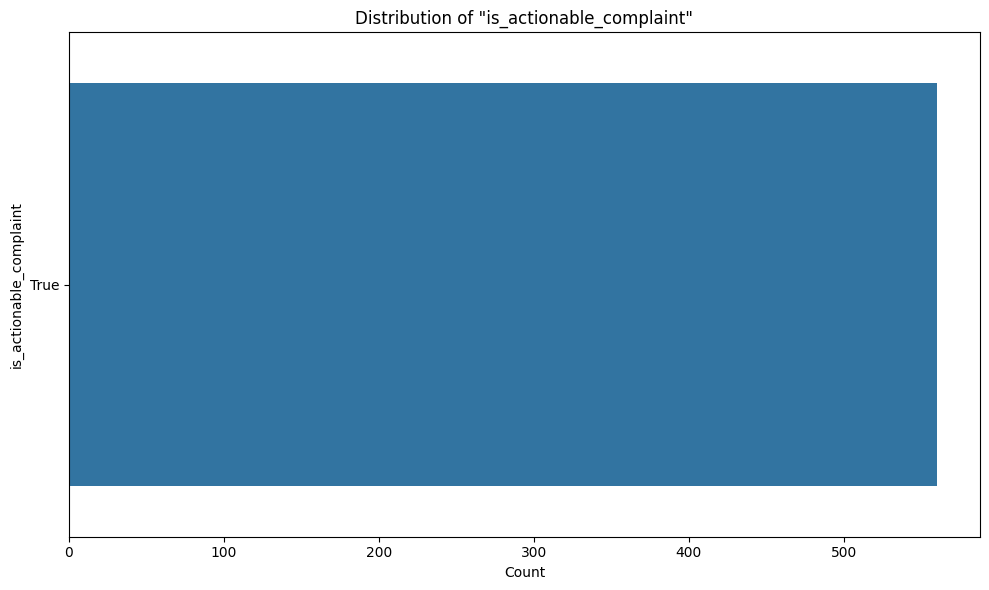


Value Counts for is_actionable_complaint:
is_actionable_complaint
True    100.0
Name: proportion, dtype: float64%



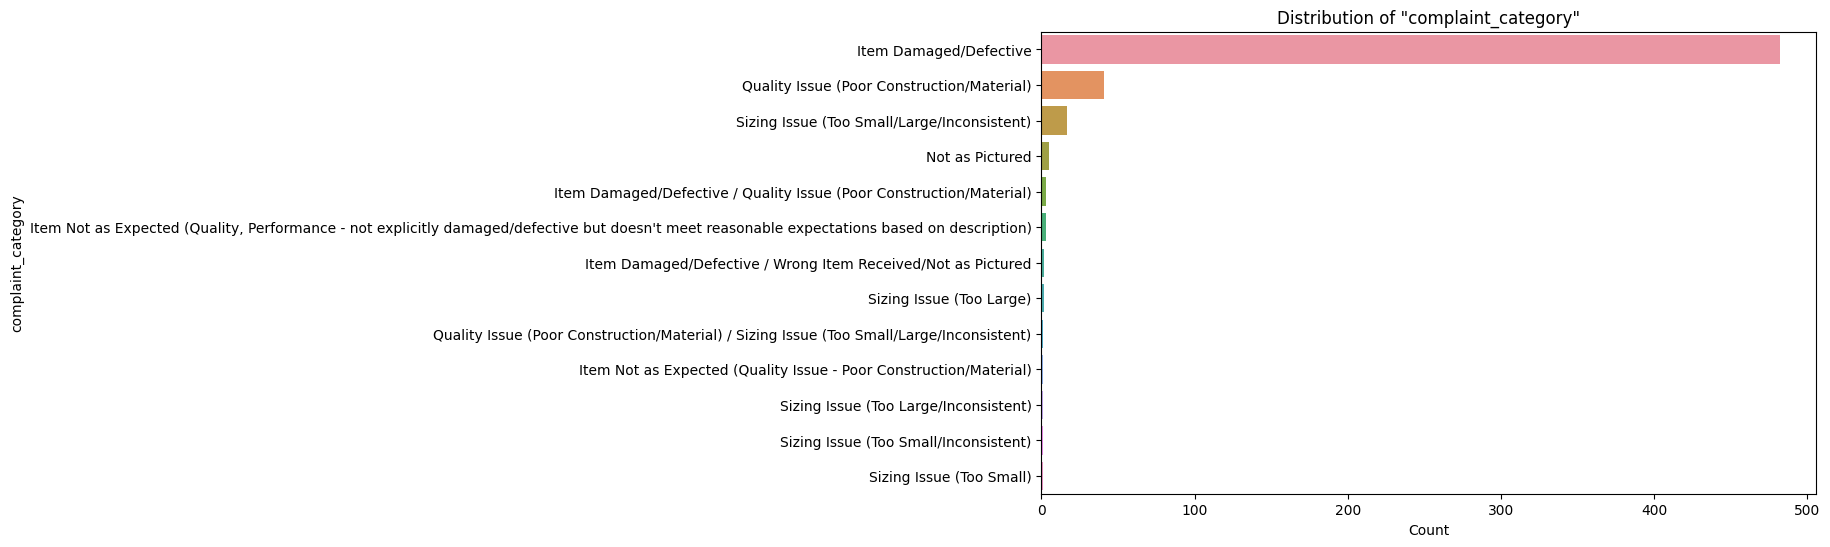


Value Counts for complaint_category:
complaint_category
Item Damaged/Defective                                                                                                                          86.071429
Quality Issue (Poor Construction/Material)                                                                                                       7.321429
Sizing Issue (Too Small/Large/Inconsistent)                                                                                                      3.035714
Not as Pictured                                                                                                                                  0.892857
Item Damaged/Defective / Quality Issue (Poor Construction/Material)                                                                              0.535714
Item Not as Expected (Quality, Performance - not explicitly damaged/defective but doesn't meet reasonable expectations based on description)     0.535714
Item Damaged/Defect

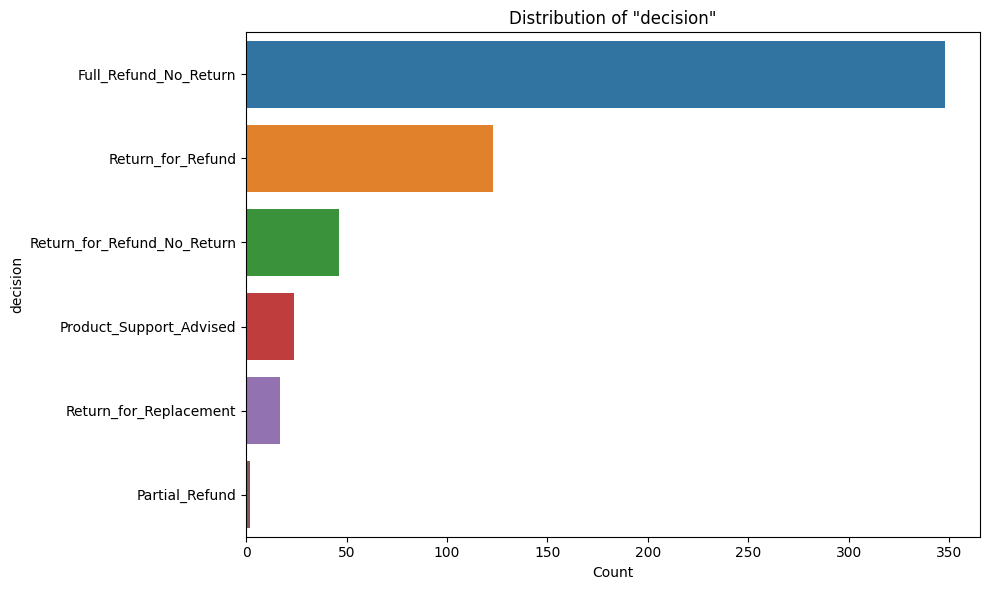


Value Counts for decision:
decision
Full_Refund_No_Return          62.142857
Return_for_Refund              21.964286
Return_for_Refund_No_Return     8.214286
Product_Support_Advised         4.285714
Return_for_Replacement          3.035714
Partial_Refund                  0.357143
Name: proportion, dtype: float64%



--- 4. Analysis of Numerical Fields ---


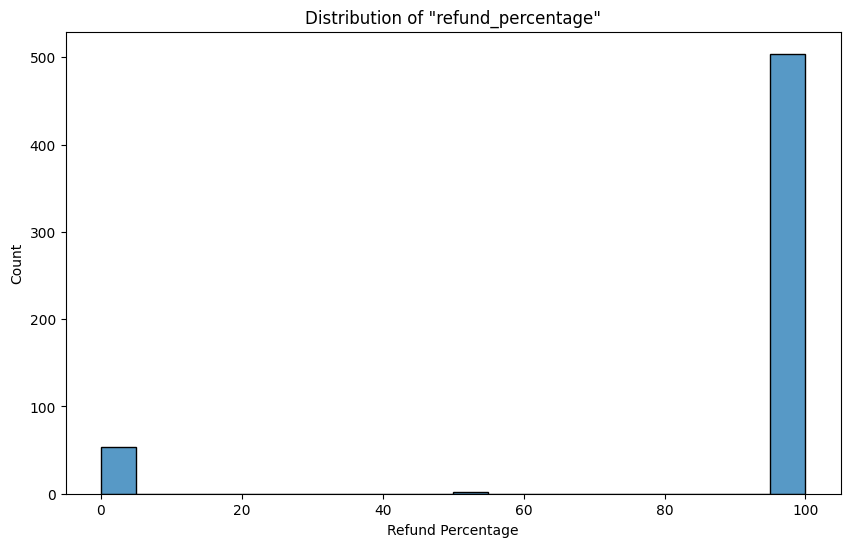


Descriptive Statistics for 'refund_percentage':
count    560.000000
mean      90.178571
std       29.636502
min        0.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: refund_percentage_numeric, dtype: float64


--- 5. Text Field Length Analysis ---


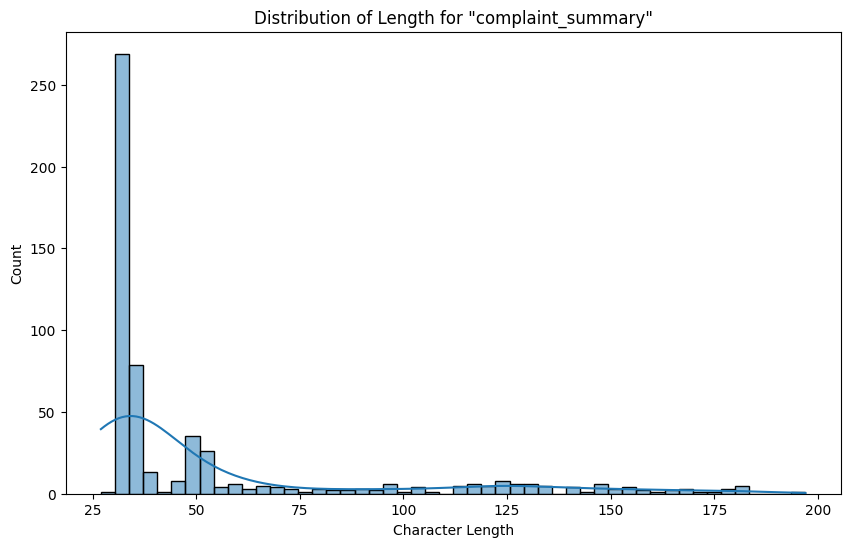


Descriptive Statistics for 'complaint_summary' length:
count    560.000000
mean      54.226786
std       38.736535
min       27.000000
25%       32.000000
50%       35.000000
75%       52.000000
max      197.000000
Name: complaint_summary_length, dtype: float64


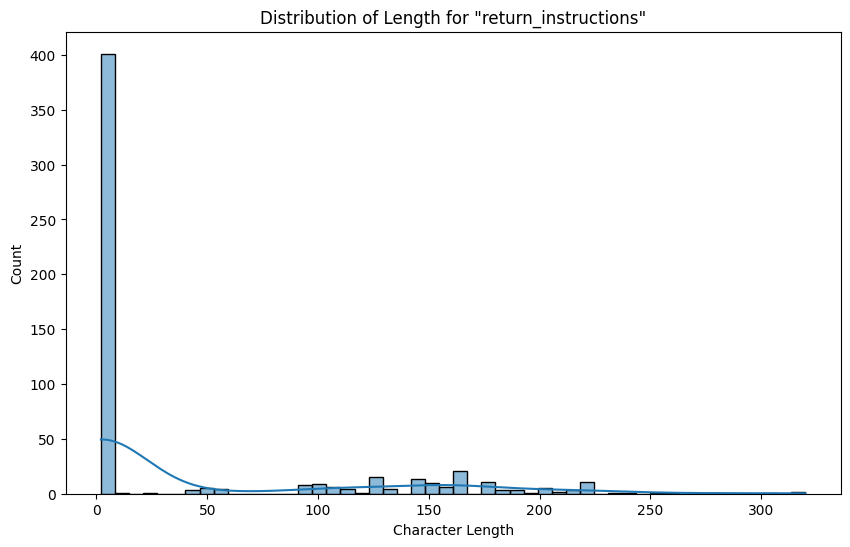


Descriptive Statistics for 'return_instructions' length:
count    560.000000
mean      44.453571
std       73.394282
min        2.000000
25%        2.000000
50%        2.000000
75%       97.000000
max      320.000000
Name: return_instructions_length, dtype: float64


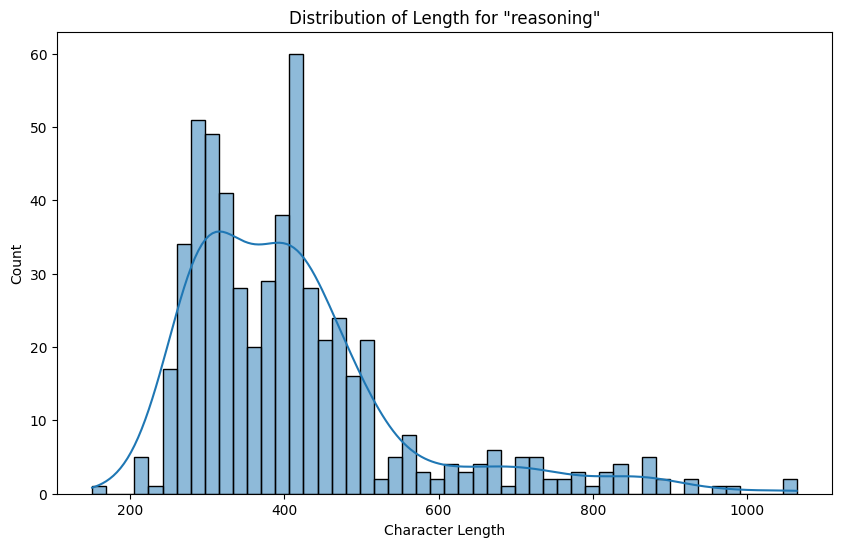


Descriptive Statistics for 'reasoning' length:
count     560.000000
mean      412.451786
std       146.262187
min       151.000000
25%       305.750000
50%       392.000000
75%       458.000000
max      1064.000000
Name: reasoning_length, dtype: float64


--- 6. Keyword/Entity Analysis (Simple Example) ---
Top 20 Most Common Key Entities:
- vase: 416
- shattered: 403
- broken: 371
- damaged box: 54
- crushed box: 32
- damaged: 23
- too small: 9
- sizing: 8
- unusable: 7
- polyester: 7
- box: 7
- cracked: 6
- cheap: 5
- poor quality: 5
- fit: 5
- packaging: 4
- thin material: 4
- size: 4
- belt: 4
- small: 4


--- 7. Qualitative Spot-Checking (Manual Review Recommended) ---
It is highly recommended to manually review a sample of the generated SFT data.
Focus on:
  - **Policy Alignment:** Does the 'decision' and 'reasoning' strictly follow the provided Amazon policy?
  - **Reasoning Quality:** Is the 'reasoning' clear, logical, and does it cite policy where appropriate?
  - **Instructio

In [12]:
### 9. Analyzing the SFT Output File (sft_complaint_resolution_dataset.jsonl)

import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

SFT_OUTPUT_FILE = "sft_complaint_resolution_dataset.jsonl" # Ensure this matches your output file

# --- 1. Load the Generated SFT Dataset ---
sft_data = []
try:
    with open(SFT_OUTPUT_FILE, 'r') as f:
        for line in f:
            try:
                sft_data.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"Skipping malformed JSON line: {line.strip()}")
    print(f"Successfully loaded {len(sft_data)} records from {SFT_OUTPUT_FILE}")
except FileNotFoundError:
    print(f"Error: SFT output file not found at {SFT_OUTPUT_FILE}. Please ensure Phase 1 completed.")
    sft_data = [] # Ensure sft_data is defined even if file not found

if not sft_data:
    print("No SFT data to analyze. Exiting analysis.")
else:
    # Extract the generated JSON payloads for easier analysis
    generated_payloads = [record.get("output_json_str") for record in sft_data if "output_json_str" in record]
    parsed_payloads = []
    for i, payload_str in enumerate(generated_payloads):
        try:
            parsed_payloads.append(json.loads(payload_str))
        except json.JSONDecodeError:
            print(f"Could not parse JSON payload for record {i}: {payload_str[:200]}...") # Print snippet of bad JSON

    if not parsed_payloads:
        print("No valid JSON payloads found in the SFT data. Cannot perform detailed analysis.")
    else:
        df_sft = pd.DataFrame(parsed_payloads)
        print(f"\n--- Initial DataFrame from SFT Payloads ({len(df_sft)} records) ---")
        print(df_sft.head())
        print(f"\nDataFrame Info:")
        df_sft.info()

        # --- 2. Schema Adherence and Field Completeness ---
        print("\n\n--- 2. Schema Adherence & Field Completeness ---")
        expected_keys = {
            "is_actionable_complaint", "complaint_category", "complaint_summary",
            "key_entities", "decision", "refund_percentage",
            "return_instructions", "reasoning"
        }
        missing_keys_count = 0
        for i, payload in enumerate(parsed_payloads):
            if not expected_keys.issubset(payload.keys()):
                missing_keys_count += 1
                # print(f"Record {i} is missing one or more expected keys. Found: {list(payload.keys())}")
        if missing_keys_count > 0:
            print(f"WARNING: {missing_keys_count}/{len(parsed_payloads)} records are missing one or more expected top-level keys.")
        else:
            print("All records adhere to the basic top-level key schema.")

        # --- 3. Distribution Analysis of Key Categorical Fields ---
        print("\n\n--- 3. Distribution Analysis of Key Categorical Fields ---")

        def plot_distribution(df, column_name, title):
            if column_name in df.columns:
                plt.figure(figsize=(10, 6))
                sns.countplot(y=df[column_name], order=df[column_name].value_counts().index)
                plt.title(title)
                plt.xlabel("Count")
                plt.ylabel(column_name)
                plt.tight_layout()
                plt.show()
                print(f"\nValue Counts for {column_name}:\n{df[column_name].value_counts(normalize=True) * 100}%\n")
            else:
                print(f"Column '{column_name}' not found for distribution analysis.")

        plot_distribution(df_sft, 'is_actionable_complaint', 'Distribution of "is_actionable_complaint"')
        plot_distribution(df_sft, 'complaint_category', 'Distribution of "complaint_category"')
        plot_distribution(df_sft, 'decision', 'Distribution of "decision"')

        # --- 4. Analysis of Numerical Fields ---
        print("\n\n--- 4. Analysis of Numerical Fields ---")
        if 'refund_percentage' in df_sft.columns:
            # Ensure it's numeric, coercing errors
            df_sft['refund_percentage_numeric'] = pd.to_numeric(df_sft['refund_percentage'], errors='coerce')
            invalid_refund_percentage = df_sft['refund_percentage_numeric'].isnull().sum()
            if invalid_refund_percentage > 0:
                print(f"WARNING: {invalid_refund_percentage} records have non-numeric 'refund_percentage'.")

            plt.figure(figsize=(10, 6))
            sns.histplot(df_sft['refund_percentage_numeric'].dropna(), bins=20, kde=False)
            plt.title('Distribution of "refund_percentage"')
            plt.xlabel("Refund Percentage")
            plt.ylabel("Count")
            plt.show()
            print("\nDescriptive Statistics for 'refund_percentage':")
            print(df_sft['refund_percentage_numeric'].dropna().describe())
            # Check for out-of-range values
            out_of_range_refunds = df_sft[
                (df_sft['refund_percentage_numeric'] < 0) | (df_sft['refund_percentage_numeric'] > 100)
            ]['refund_percentage_numeric']
            if not out_of_range_refunds.empty:
                print(f"\nWARNING: Found {len(out_of_range_refunds)} refund percentages outside the 0-100 range: {out_of_range_refunds.tolist()}")
        else:
            print("Column 'refund_percentage' not found for numerical analysis.")


        # --- 5. Text Field Length Analysis ---
        print("\n\n--- 5. Text Field Length Analysis ---")
        text_fields = ['complaint_summary', 'return_instructions', 'reasoning']
        for field in text_fields:
            if field in df_sft.columns:
                df_sft[f'{field}_length'] = df_sft[field].astype(str).apply(len)
                plt.figure(figsize=(10, 6))
                sns.histplot(df_sft[f'{field}_length'], bins=50, kde=True)
                plt.title(f'Distribution of Length for "{field}"')
                plt.xlabel("Character Length")
                plt.ylabel("Count")
                plt.show()
                print(f"\nDescriptive Statistics for '{field}' length:")
                print(df_sft[f'{field}_length'].describe())
            else:
                print(f"Column '{field}' not found for text length analysis.")

        # --- 6. Keyword/Entity Analysis (Simple Example) ---
        print("\n\n--- 6. Keyword/Entity Analysis (Simple Example) ---")
        if 'key_entities' in df_sft.columns:
            all_entities = []
            for entities_list in df_sft['key_entities'].dropna():
                if isinstance(entities_list, list):
                    all_entities.extend([str(e).lower() for e in entities_list]) # Ensure string and lowercase

            if all_entities:
                entity_counts = Counter(all_entities)
                print("Top 20 Most Common Key Entities:")
                for entity, count in entity_counts.most_common(20):
                    print(f"- {entity}: {count}")
            else:
                print("No key entities found or 'key_entities' column has unexpected data.")
        else:
            print("Column 'key_entities' not found for entity analysis.")

        # --- 7. Qualitative Spot-Checking (Instructions for Manual Review) ---
        print("\n\n--- 7. Qualitative Spot-Checking (Manual Review Recommended) ---")
        print("It is highly recommended to manually review a sample of the generated SFT data.")
        print("Focus on:")
        print("  - **Policy Alignment:** Does the 'decision' and 'reasoning' strictly follow the provided Amazon policy?")
        print("  - **Reasoning Quality:** Is the 'reasoning' clear, logical, and does it cite policy where appropriate?")
        print("  - **Instruction Correctness:** Are 'return_instructions' accurate and complete when applicable?")
        print("  - **Summary Conciseness:** Is the 'complaint_summary' a good, brief representation of the issue?")
        print("  - **Edge Cases:** How well did the model handle potentially ambiguous or complex complaints?")

        if len(df_sft) > 0:
            print("\nRandom Sample for Manual Review (first 5 records):")
            sample_for_review = []
            original_prompts = [record.get("input_context_and_complaint") for record in sft_data if "input_context_and_complaint" in record]

            for i in range(min(5, len(parsed_payloads))):
                review_item = {"original_prompt_input_snippet": original_prompts[i][:500] + "..." if i < len(original_prompts) else "N/A",
                               "generated_output": parsed_payloads[i]}
                sample_for_review.append(review_item)

            # Pretty print the sample
            for i, item in enumerate(sample_for_review):
                print(f"\n--- Sample Record {i+1} ---")
                print(f"Original Prompt Snippet:\n{item['original_prompt_input_snippet']}")
                print(f"Generated Output (JSON):\n{json.dumps(item['generated_output'], indent=2)}")
        else:
            print("No data available to show a random sample.")

        # --- 8. Further Advanced Analysis Ideas (Not Implemented Here) ---
        print("\n\n--- 8. Further Advanced Analysis Ideas ---")
        print("- **Semantic Consistency:** Use sentence embeddings to check if 'complaint_summary' is semantically similar to the original review text (if available).")
        print("- **Bias Detection:** Analyze if decisions or reasoning show bias related to product types, complaint phrasing, etc. (requires more sophisticated NLP).")
        print("- **Duplicate/Near-Duplicate Detection:** Check for highly similar generated outputs or input prompts that led to them.")
        print("- **Model-Based Evaluation (Self-Correction/Critique):** Use another LLM (or even the same teacher model with a different prompt) to critique the generated JSON for quality, policy adherence, and clarity.")
        print("- **Inter-Annotator Agreement (if multiple generation runs/models):** If you generate data with different settings or models, compare their outputs.")

In [15]:
### 10. Fine-Tuning "google/gemma-3-4b-it" (Simplified SFTTrainer Call)

import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    logging as hf_logging
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer, SFTConfig
import traceback
import os
import time
from tqdm.auto import tqdm
import json

# --- 1. Configuration (Essential variables from skipped cells + SFT defaults) ---
STUDENT_MODEL_ID = "google/gemma-3-4b-it"
SFT_OUTPUT_FILE = "/notebooks/sft_complaint_resolution_dataset.jsonl" # Path to your existing SFT file
MAX_SFT_EXAMPLES = 566 # Using the 566 valid examples you generated
SEED = 42

FINE_TUNED_MODEL_ADAPTER_PATH = "./gemma3-4b-it-sft-lora-final_attempt"
TOKENIZER_SAVE_PATH = FINE_TUNED_MODEL_ADAPTER_PATH

LOG_LEVEL = hf_logging.INFO
hf_logging.set_verbosity(LOG_LEVEL)

# LoRA parameters
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.05
LORA_TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

# Training parameters for SFTConfig
OUTPUT_DIR = "./results_gemma3_4b_lora_final_attempt"
NUM_TRAIN_EPOCHS = 1
PER_DEVICE_TRAIN_BATCH_SIZE = 1 # Keep low for larger models on single GPU
GRADIENT_ACCUMULATION_STEPS = 4 # Effective batch size = 1 * 4 = 4
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
MAX_SEQ_LENGTH = 512 # Adjust based on your data and GPU memory
DATASET_TEXT_FIELD = "text"
USE_BF16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
USE_FP16 = not USE_BF16 and torch.cuda.is_available()
GRADIENT_CHECKPOINTING = True

# SFTConfig specific parameters (previously missing, added defaults)
OPTIM = "adamw_torch"
SAVE_STRATEGY = "steps"
SAVE_STEPS = 100 # Save less frequently for a small dataset, or "epoch"
LOGGING_STEPS = 10
MAX_GRAD_NORM = 0.3
WARMUP_RATIO = 0.03
GROUP_BY_LENGTH = True
LR_SCHEDULER_TYPE = "cosine"
PACKING = False # Explicitly set packing

# --- 2. Load and Prepare SFT Dataset ---
print(f"Loading SFT dataset from: {SFT_OUTPUT_FILE}")
raw_train_dataset = None
raw_eval_dataset = None
try:
    if not os.path.exists(SFT_OUTPUT_FILE):
        raise FileNotFoundError(f"SFT dataset file not found at {SFT_OUTPUT_FILE}. Please ensure the path is correct and the file exists.")
    
    raw_dataset_full = load_dataset("json", data_files=SFT_OUTPUT_FILE, split="train")
    if len(raw_dataset_full) == 0: raise ValueError("SFT dataset file is empty.")
    
    num_samples_to_use = min(len(raw_dataset_full), MAX_SFT_EXAMPLES)
    dataset_to_process = raw_dataset_full.select(range(num_samples_to_use))
    print(f"Using {len(dataset_to_process)} samples for this run.")

    if len(dataset_to_process) > 10 : # Ensure enough for a small eval set
        test_size_dynamic = max(1, int(0.1 * len(dataset_to_process))) # e.g., 10% for eval
        if len(dataset_to_process) - test_size_dynamic > 0:
             dataset_split = dataset_to_process.train_test_split(test_size=test_size_dynamic, seed=SEED)
             train_dataset_raw = dataset_split["train"]
             eval_dataset_raw = dataset_split["test"]
        else:
            train_dataset_raw = dataset_to_process
            eval_dataset_raw = None
    else:
        train_dataset_raw = dataset_to_process
        eval_dataset_raw = None
        
    print(f"Using {len(train_dataset_raw)} raw training samples.")
    if eval_dataset_raw: print(f"Using {len(eval_dataset_raw)} raw evaluation samples.")

except Exception as e:
    print(f"Error loading or splitting dataset: {e}"); traceback.print_exc(); raise

def format_example_for_sft(example):
    instruction = example.get('instruction', '')
    input_context = example.get('input_context_and_complaint', '')
    response_json = example.get('output_json_str', '')
    return {"text": f"### Instruction:\n{instruction}\n\n### Input:\n{input_context}\n\n### Response:\n{response_json}"}

print("Applying formatting to create 'text' field...")
formatted_train_dataset = train_dataset_raw.map(format_example_for_sft, remove_columns=list(train_dataset_raw.column_names))
formatted_eval_dataset = None
if eval_dataset_raw:
    formatted_eval_dataset = eval_dataset_raw.map(format_example_for_sft, remove_columns=list(eval_dataset_raw.column_names))
print(f"Formatted training dataset ready with {len(formatted_train_dataset)} samples.")
if formatted_eval_dataset:
    print(f"Formatted evaluation dataset ready with {len(formatted_eval_dataset)} samples.")

# --- 3. Load Model & Tokenizer ---
print(f"Loading student model: {STUDENT_MODEL_ID}")
dtype_to_use = torch.bfloat16 if USE_BF16 else torch.float16
print(f"Using torch_dtype: {dtype_to_use} for model loading.")

# --- 3. Load Model & Tokenizer ---
print(f"Loading student model: {STUDENT_MODEL_ID}")
dtype_to_use = torch.bfloat16 if USE_BF16 else torch.float16
print(f"Using torch_dtype: {dtype_to_use} for model loading.")

# Load the main configuration first
main_config = AutoConfig.from_pretrained(STUDENT_MODEL_ID, trust_remote_code=True)

# Extract the text-specific configuration
text_specific_config = main_config.text_config

# Load the model initially to CPU to ensure all parameters are materialized
# We will then apply device_map
print("Loading model weights to CPU first...")
model = AutoModelForCausalLM.from_pretrained(
    STUDENT_MODEL_ID,
    config=text_specific_config, # Use the extracted text_config here
    torch_dtype=dtype_to_use,
    # device_map="auto", # Remove device_map for initial CPU load
    trust_remote_code=True,
)
print("Model weights loaded to CPU.")

# Now, if a GPU is available, apply device_map to distribute the model
if torch.cuda.is_available():
    print("Applying device_map='auto' to move/distribute model to GPU(s)...")
    # This re-assigns the model variable after accelerate has dispatched it
    from accelerate import dispatch_model
    device_map = {"": "cuda:0"} # Or let accelerate choose with just "auto" if you have multiple small GPUs
                                # For a single GPU, {"": "cuda:0"} or {"": "cuda"} is usually fine.
                                # If "auto" still causes issues, explicitly mapping to cuda:0 can help.
    
    # It seems Gemma3's from_pretrained might not fully support passing device_map
    # after initial config. Let's try re-loading with device_map if the above doesn't work
    # or directly using .to(device) if it's a single GPU and fits.

    # Option A: Try .to(device) if it fits on a single GPU
    try:
        model = model.to(torch.device("cuda"))
        print("Model successfully moved to GPU using .to('cuda')")
    except Exception as e_to:
        print(f"Failed to move model to GPU using .to('cuda'): {e_to}")
        print("Attempting from_pretrained with device_map='auto' directly (might re-download if not cached properly)")
        # Option B: Reload with device_map if .to(device) fails (e.g. OOM)
        # This is less ideal as it might re-download or re-process.
        try:
            del model # Clear previous CPU model
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            model = AutoModelForCausalLM.from_pretrained(
                STUDENT_MODEL_ID,
                config=text_specific_config,
                torch_dtype=dtype_to_use,
                device_map="auto", # Apply device_map now
                trust_remote_code=True,
            )
            print("Model re-loaded with device_map='auto'.")
        except Exception as e_dm:
            print(f"Failed to load model with device_map='auto': {e_dm}")
            print("Falling back to CPU.")
            # Ensure model is on CPU if GPU attempts fail
            model = model.to(torch.device("cpu"))


else:
    print("CUDA not available. Model remains on CPU.")

print(f"Base model loaded. Device: {model.device}")


# Tokenizer loading remains the same, but its config for pad/eos also comes from main_config
tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL_ID, trust_remote_code=True)
model_config_for_tokens = main_config # Use main_config for tokenizer's pad/eos setup
# ... rest of the tokenizer setup (as you had it, using model_config_for_tokens) ...
# EOS Token
if isinstance(model_config_for_tokens.eos_token_id, list):
    tokenizer.eos_token_id = model_config_for_tokens.eos_token_id[0]
else:
    tokenizer.eos_token_id = model_config_for_tokens.eos_token_id
if tokenizer.eos_token_id is None: # Fallback if not in config
    tokenizer.eos_token_id = 1 # Common for Gemma
tokenizer.eos_token = tokenizer.decode([tokenizer.eos_token_id]) if tokenizer.eos_token_id is not None else "<eos>"


# PAD Token
if tokenizer.pad_token_id is None or tokenizer.pad_token_id == tokenizer.eos_token_id:
    if hasattr(model_config_for_tokens, 'pad_token_id') and \
       model_config_for_tokens.pad_token_id is not None and \
       model_config_for_tokens.pad_token_id != tokenizer.eos_token_id:
        tokenizer.pad_token_id = model_config_for_tokens.pad_token_id
    else:
        tokenizer.pad_token_id = 0 # Common for Gemma, if not EOS
    tokenizer.pad_token = tokenizer.decode([tokenizer.pad_token_id])
    if not tokenizer.pad_token.strip() or tokenizer.pad_token == tokenizer.eos_token:
        tokenizer.pad_token = "<pad>" # Fallback string

tokenizer.padding_side = "right"

print(f"Tokenizer: PAD ID: {tokenizer.pad_token_id} ('{tokenizer.pad_token}'), EOS ID: {tokenizer.eos_token_id} ('{tokenizer.eos_token}'), Padding Side: {tokenizer.padding_side}")
if tokenizer.pad_token_id == tokenizer.eos_token_id:
    print("\nCRITICAL WARNING: Tokenizer PAD_ID IS SAME AS EOS_ID! This will cause issues.")
    if tokenizer.eos_token_id == 0 and tokenizer.pad_token_id == 0: # Attempt common Gemma fix
        print("Attempting to set EOS to 1 ('<eos>') and PAD to 0 ('<pad>') for Gemma.")
        tokenizer.eos_token_id = 1 ; tokenizer.eos_token = "<eos>"
        tokenizer.pad_token_id = 0 ; tokenizer.pad_token = "<pad>"
        print(f"REVISED Tokenizer: PAD ID: {tokenizer.pad_token_id} ('{tokenizer.pad_token}'), EOS ID: {tokenizer.eos_token_id} ('{tokenizer.eos_token}')")
        if tokenizer.pad_token_id == tokenizer.eos_token_id:
             raise ValueError("Failed to set distinct PAD and EOS token IDs.")

# --- 4. Configure LoRA ---
if GRADIENT_CHECKPOINTING:
    if hasattr(model, "gradient_checkpointing_enable"):
        model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant":False})
    if hasattr(model.config, 'use_cache'): model.config.use_cache = False
    print("Gradient checkpointing enabled.")

lora_config = LoraConfig(
    r=LORA_R, lora_alpha=LORA_ALPHA, target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT, bias="none", task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)
print("LoRA adapter applied."); model.print_trainable_parameters()

# --- 5. SFTConfig ---
# Corrected indentation for the dictionary
sft_config_dict = {
    "output_dir": OUTPUT_DIR,
    "num_train_epochs": NUM_TRAIN_EPOCHS,
    "per_device_train_batch_size": PER_DEVICE_TRAIN_BATCH_SIZE,
    "gradient_accumulation_steps": GRADIENT_ACCUMULATION_STEPS,
    "optim": OPTIM,
    "save_strategy": SAVE_STRATEGY,
    "save_steps": SAVE_STEPS,
    "logging_steps": LOGGING_STEPS,
    "learning_rate": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "max_grad_norm": MAX_GRAD_NORM,
    "warmup_ratio": WARMUP_RATIO,
    "group_by_length": GROUP_BY_LENGTH,
    "lr_scheduler_type": LR_SCHEDULER_TYPE,
    "report_to": "tensorboard",
    "ddp_find_unused_parameters": False,
    "dataset_text_field": DATASET_TEXT_FIELD,
    "max_seq_length": MAX_SEQ_LENGTH,
    "packing": PACKING, # Use defined variable
}
if USE_BF16: sft_config_dict["bf16"] = True; sft_config_dict["fp16"] = False
elif USE_FP16: sft_config_dict["fp16"] = True; sft_config_dict["bf16"] = False

if formatted_eval_dataset:
    sft_config_dict["evaluation_strategy"] = "steps"
    sft_config_dict["eval_steps"] = SAVE_STEPS
    sft_config_dict["per_device_eval_batch_size"] = PER_DEVICE_TRAIN_BATCH_SIZE
else:
    sft_config_dict["evaluation_strategy"] = "no"

if GRADIENT_CHECKPOINTING:
    sft_config_dict["gradient_checkpointing"] = True
    sft_config_dict["gradient_checkpointing_kwargs"] = {"use_reentrant": False}

sft_training_args = SFTConfig(**sft_config_dict)

# --- 6. SFTTrainer Instantiation ---
print("Instantiating SFTTrainer...")
trainer = SFTTrainer(
    model=model,                # PeftModel (which should have model.tokenizer set)
    args=sft_training_args,     # SFTConfig object
    train_dataset=formatted_train_dataset, # Dataset with "text" field
    eval_dataset=formatted_eval_dataset
    # Tokenizer is typically inferred from the model if model.tokenizer is set,
    # or SFTConfig might have tokenizer_name/path fields in some trl versions.
    # For recent trl versions, passing the model with model.tokenizer set is usually sufficient.
)

# --- 7. Training ---
print("\nStarting SFT (LoRA) fine-tuning...")
try:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    start_train_time = time.time()
    train_result = trainer.train()
    end_train_time = time.time()
    
    print(f"Fine-tuning completed in {(end_train_time - start_train_time)/60:.2f} minutes.")
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics); trainer.save_metrics("train", metrics)
    
    print(f"Saving LoRA adapter to {FINE_TUNED_MODEL_ADAPTER_PATH}...")
    trainer.save_model(FINE_TUNED_MODEL_ADAPTER_PATH)
    
    if TOKENIZER_SAVE_PATH:
        tokenizer.save_pretrained(TOKENIZER_SAVE_PATH)
        print(f"Tokenizer saved to {TOKENIZER_SAVE_PATH}")
    else:
        tokenizer.save_pretrained(FINE_TUNED_MODEL_ADAPTER_PATH)
        print(f"Tokenizer saved to {FINE_TUNED_MODEL_ADAPTER_PATH}")
        
    print(f"LoRA adapter and tokenizer saved.")

except Exception as e:
    print(f"An error occurred during training: {e}"); traceback.print_exc()

finally:
    if hasattr(model, 'device') and model.device.type == 'cuda':
        print("Cleaning up model from GPU...")
        del model
        if 'teacher_model' in globals() and teacher_model is not None:
            del teacher_model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("GPU cleanup attempt complete.")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/config.json
text_config is None, using default Gemma3TextConfig vision config.
vision_config is None or incompatible with Gemma3VisionConfig intialization. Gemma3 will be limited to text tasks.
Model config Gemma3Config {
  "architectures": [
    "Gemma3ForConditionalGeneration"
  ],
  "boi_token_index": 255999,
  "eoi_token_index": 256000,
  "eos_token_id": [
    1,
    106
  ],
  "image_token_index": 262144,
  "initializer_range": 0.02,
  "mm_tokens_per_image": 256,
  "model_type": "gemma3",
  "text_config": {
    "attention_bias": false,
    "attention_dropout": 0.0,
    "attn_logit_softcapping": null,
    "cache_implementation": "hybrid",
    "final_logit_softcapping": null,
    "head_dim": 256,
    "hidden_activation": "gelu_pytorch_tanh",
    "hidden_size": 2560,
    "initializer_range": 0.02,
    "intermediate_size": 1

Loading SFT dataset from: /notebooks/sft_complaint_resolution_dataset.jsonl
Using 560 samples for this run.
Using 504 raw training samples.
Using 56 raw evaluation samples.
Applying formatting to create 'text' field...
Formatted training dataset ready with 504 samples.
Formatted evaluation dataset ready with 56 samples.
Loading student model: google/gemma-3-4b-it
Using torch_dtype: torch.float16 for model loading.
Loading student model: google/gemma-3-4b-it
Using torch_dtype: torch.float16 for model loading.
Loading model weights to CPU first...


loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/model.safetensors.index.json
Instantiating Gemma3ForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "pad_token_id": 0
}



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at google/gemma-3-4b-it were not used when initializing Gemma3ForCausalLM: {'vision_tower.vision_model.encoder.layers.17.self_attn.v_proj.weight', 'vision_tower.vision_model.encoder.layers.20.self_attn.k_proj.weight', 'vision_tower.vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_tower.vision_model.encoder.layers.21.layer_norm1.weight', 'vision_tower.vision_model.encoder.layers.9.self_attn.v_proj.bias', 'vision_tower.vision_model.encoder.layers.15.mlp.fc1.bias', 'vision_tower.vision_model.encoder.layers.11.mlp.fc2.bias', 'vision_tower.vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_tower.vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_tower.vision_model.encoder.layers.26.self_attn.q_proj.bias', 'vision_tower.vision_model.encoder.layers.9.self_attn.q_proj.weight', 'vision_tower.vision_model.encoder.layers.12.layer_norm1.weight', 'vision_tower.vision_model.encoder.layers.23.self_attn.v_proj.bias', 'vision

Model weights loaded to CPU.
Applying device_map='auto' to move/distribute model to GPU(s)...


loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/tokenizer.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/tokenizer.json
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/tokenizer_config.json
loading file chat_template.jinja from cache at None


Model successfully moved to GPU using .to('cuda')
Base model loaded. Device: cuda:0
Tokenizer: PAD ID: 0 ('<pad>'), EOS ID: 1 ('<eos>'), Padding Side: right
Gradient checkpointing enabled.


PyTorch: setting up devices
loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/tokenizer.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/tokenizer.json
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/tokenizer_config.json
loading file chat_template.jinja from cache at None


LoRA adapter applied.
trainable params: 14,901,248 || all params: 3,895,164,416 || trainable%: 0.38255761268486593
Instantiating SFTTrainer...


Converting train dataset to ChatML:   0%|          | 0/504 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/504 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/504 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/504 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/56 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/56 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/56 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/56 [00:00<?, ? examples/s]

[2025-05-16 11:05:00,572] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Using auto half precision backend
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.



Starting SFT (LoRA) fine-tuning...


***** Running training *****
  Num examples = 504
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 126
  Number of trainable parameters = 14,901,248
It is strongly recommended to train Gemma3 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss,Validation Loss
100,0.000000,nan


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 56
  Batch size = 1
Saving model checkpoint to ./results_gemma3_4b_lora_final_attempt/checkpoint-100
tokenizer config file saved in ./results_gemma3_4b_lora_final_attempt/checkpoint-100/tokenizer_config.json
Special tokens file saved in ./results_gemma3_4b_lora_final_attempt/checkpoint-100/special_tokens_map.json
Saving model checkpoint to ./results_gemma3_4b_lora_final_attempt/checkpoint-126
tokenizer config file saved in ./results_gemma3_4b_lora_final_attempt/checkpoint-126/tokenizer_config.json
Special tokens file saved in ./results_gemma3_4b_lora_final_attempt/checkpoint-126/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model ch

Fine-tuning completed in 7.37 minutes.
***** train metrics *****
  total_flos               =  4648737GF
  train_loss               =        0.0
  train_runtime            = 0:07:21.57
  train_samples_per_second =      1.141
  train_steps_per_second   =      0.285
Saving LoRA adapter to ./gemma3-4b-it-sft-lora-final_attempt...


tokenizer config file saved in ./gemma3-4b-it-sft-lora-final_attempt/tokenizer_config.json
Special tokens file saved in ./gemma3-4b-it-sft-lora-final_attempt/special_tokens_map.json
tokenizer config file saved in ./gemma3-4b-it-sft-lora-final_attempt/tokenizer_config.json
Special tokens file saved in ./gemma3-4b-it-sft-lora-final_attempt/special_tokens_map.json


Tokenizer saved to ./gemma3-4b-it-sft-lora-final_attempt
LoRA adapter and tokenizer saved.
Cleaning up model from GPU...
GPU cleanup attempt complete.


In [ ]:
#output